In [1]:
import importlib
import micasense.imageset
import micasense.capture
import micasense.imageset as imageset
import micasense.capture as capture
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import exiftool
import datetime
from math import ceil
from tqdm import tqdm

import algorithms.mutils as mutils
import algorithms.radiometric_calib_utils as rcu
import algorithms.extract_spectral as espect
import algorithms.flight_attributes
import algorithms.validate_algorithm

importlib.reload(algorithms.validate_algorithm)
importlib.reload(algorithms.flight_attributes)

import algorithms.flight_attributes as FlightAttributes
import algorithms.validate_algorithm as ValidateAlgo

In [2]:
mutils.get_ground_resolution(60)

(0.04095836789448961, 0.03989258867239755)

# Get panel images, panel reflectance, warp matrices

In [3]:
panelNames = None
useDLS = True

imagePath =  r"D:\EPMC_flight\pandanResTest\F1\RawImg"#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
panelNames = glob.glob(os.path.join(imagePath,'IMG_0003_*.tif'))

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # Set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = micasense.capture.Capture.from_filelist(panelNames)
    warp_matrices = panelCap.get_warp_matrices()
    cropped_dimensions, _ = micasense.imageutils.find_crop_bounds(panelCap, warp_matrices, warp_mode=cv2.MOTION_HOMOGRAPHY)
    print(cropped_dimensions)
else:
    panelCap = None
    warp_matrices = None
if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.65]*len(panelCap.images) #inexact, but quick
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

(4.0, 6.0, 1239.0, 919.0)


# Batch import and process all images

In [4]:
# batch import images
imgset = imageset.ImageSet.from_directory(imagePath)

use_multi_process = True # set to False for single-process saving
overwrite_existing = False # skip existing files, set to True to overwrite

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# If we didn't provide a panel above, irradiance set to None will cause DLS data to be used
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start_time = datetime.datetime.now()

# Save all captures in the imageset as aligned stacks
imgset.process_imageset(outputPath,
                     thumbnailPath,
                     warp_matrices,
                     irradiance = irradiance,
                     img_type='reflectance',
                     multiprocess=use_multi_process, 
                     overwrite=overwrite_existing)

end_time = datetime.datetime.now()

print("Saving time: {}".format(end_time-start_time))
print("Alignment+Saving rate: {:.2f} captures per second".format(float(len(imgset.captures))/float((end_time-start_time).total_seconds())))

Loading ImageSet from: D:\EPMC_flight\pandanResTest\F1\RawImg
Processing 111 Captures ...
Processing complete.
Saving time: 0:02:36.456195
Alignment+Saving rate: 0.71 captures per second


## Import saved band_aligned images

In [5]:
imagePath =  r"D:\EPMC_flight\pandanResTest\F1\RawImg"
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0012_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0013_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F1\\thumbnails\\IMG_0014_1.j

## Import flight attributes df

In [6]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
0,2022-12-12 03:10:41.592159+00:00,1.319144,103.736459,21.701,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,2.200871,-0.061801,-0.005401,0.537403,0.472191,0.396261,0.243734,0.307251,0.477810,0.491289,0.390115,0.350913,0.325066
1,2022-12-12 03:31:51.550140+00:00,1.318990,103.736565,10.502,IMG_0001_1.tif,Sgj8p3v3VixUWqiXci3d,1.861459,-0.078960,-0.023297,0.531005,0.469161,0.397455,0.244385,0.307143,0.469790,0.487245,0.390228,0.351441,0.325695
2,2022-12-12 03:32:07.457042+00:00,1.318990,103.736565,10.344,IMG_0002_1.tif,BfqpZAn1ENF5mZF7Y0ym,1.901786,-0.081657,-0.048236,0.528206,0.466644,0.395320,0.243102,0.305549,0.467343,0.484658,0.388152,0.349590,0.323969
3,2022-12-12 03:32:23.747743+00:00,1.318990,103.736564,9.204,IMG_0003_1.tif,G3XbYFvYATY8OUGMn25g,1.860537,-0.045719,0.027699,0.521876,0.460987,0.390730,0.240315,0.302123,0.461643,0.478821,0.383631,0.345641,0.320315
4,2022-12-12 03:48:28.193927+00:00,1.318992,103.736563,48.959,IMG_0004_1.tif,Gniksxrb5NGU9Dcqx7lU,1.945369,0.002227,-0.049009,0.555389,0.492866,0.413670,0.255678,0.319040,0.495360,0.511189,0.407412,0.364172,0.336899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2022-12-12 03:51:40.457728+00:00,1.318892,103.736483,50.118,IMG_0106_1.tif,U12AzrV6csZZHgfn1qvH,0.688926,-0.098680,-0.072529,0.563019,0.498879,0.417811,0.258192,0.322382,0.502634,0.517682,0.411673,0.367928,0.340393
107,2022-12-12 03:51:42.679643+00:00,1.318925,103.736505,50.232,IMG_0107_1.tif,z8PLfX1WW10WM52lXksP,0.684994,-0.099071,-0.076829,0.562800,0.498700,0.417704,0.258102,0.322252,0.502401,0.517486,0.411538,0.367813,0.340297
108,2022-12-12 03:51:44.874407+00:00,1.318958,103.736528,50.275,IMG_0108_1.tif,ObZOcV3eerYztqOgfJDU,0.681796,-0.098410,-0.076524,0.562555,0.498498,0.417564,0.257998,0.322104,0.502159,0.517267,0.411378,0.367670,0.340172
109,2022-12-12 03:51:47.225561+00:00,1.318992,103.736551,50.310,IMG_0109_1.tif,6buZl1kDz7Di2WNECdqv,0.671411,-0.009431,-0.084567,0.562565,0.498573,0.417628,0.258049,0.322144,0.502186,0.517323,0.411450,0.367706,0.340196


### View flight altitude

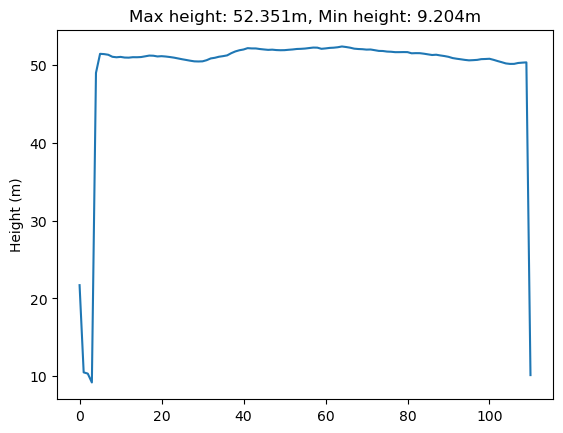

In [7]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
height_max = np.max(flight_attributes_df['altitude'].values)
height_min = np.min(flight_attributes_df['altitude'].values)
plt.title(f'Max height: {height_max}m, Min height: {height_min}m')
plt.ylabel('Height (m)')
plt.show()

# Detect points

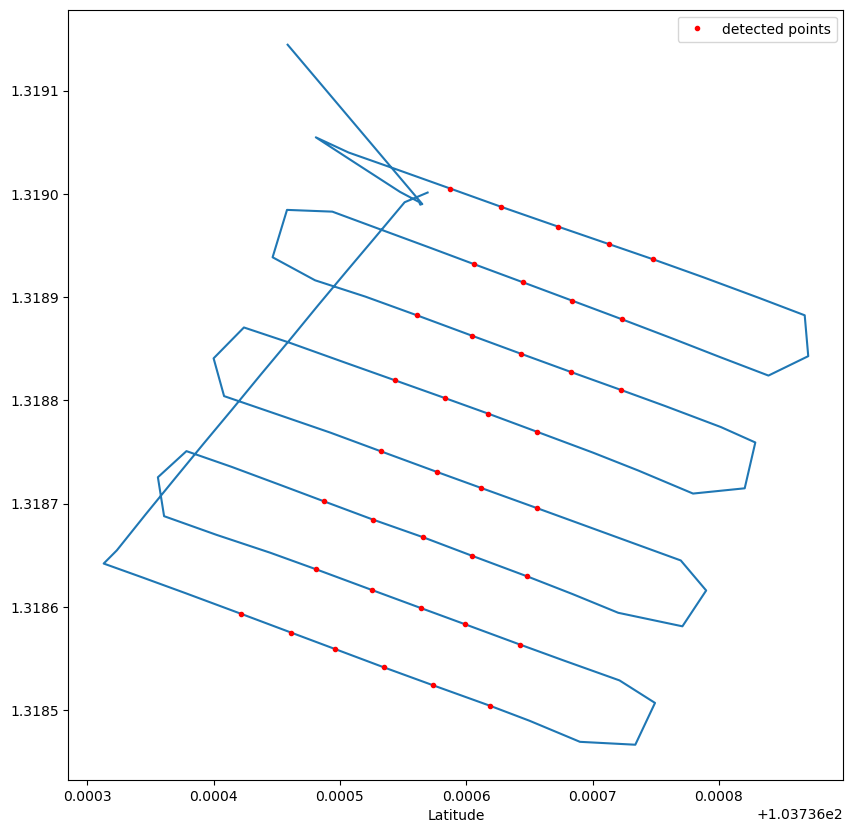

In [8]:
DL = FlightAttributes.DetectLines(flight_attributes_df, n = 3, thresh=0.99, plot=True)
flight_points = DL.get_points()

In [9]:
print(flight_points)

[10, 11, 12, 13, 14, 22, 23, 24, 25, 33, 34, 35, 36, 37, 45, 46, 47, 48, 56, 57, 58, 59, 67, 68, 69, 70, 71, 79, 80, 81, 82, 83, 90, 91, 92, 93, 94, 95]


## Interpolate Flight
- estimate flight angle using coordinates (`estimate_angle = "calculate"`)
- estimate flight angle using yaw (`estimate_angle = "yaw"`)

0it [00:00, ?it/s]

111it [00:00, 1260.33it/s]
111it [00:00, 1478.54it/s]


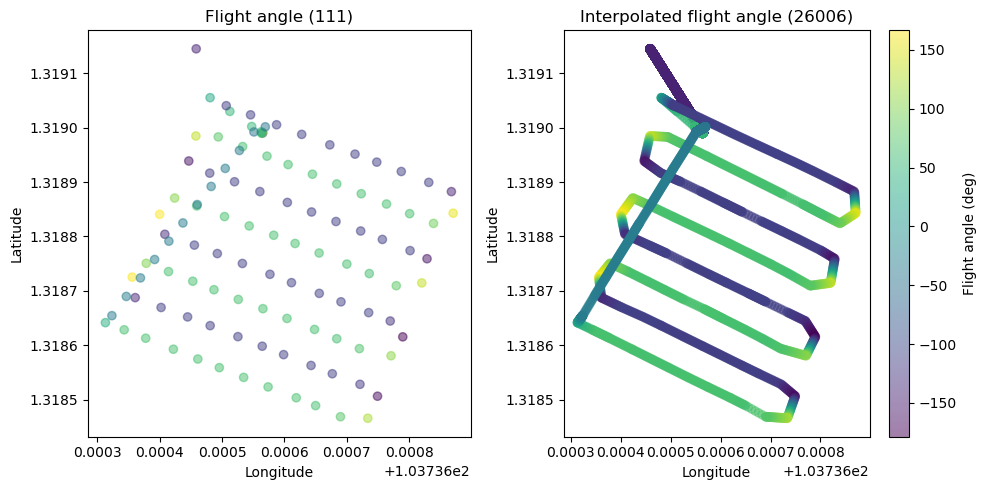

,timestamp,timedelta,latitude,longitude,altitude,flight_angle,north_vec,east_vec,image_name,capture_id,...,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,index
0,2022-12-12 03:10:41.592159+00:00,0.0,1.319144,103.736459,21.701000,-145.504078,-1.0,1.0,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,...,0.472191,0.396261,0.243734,0.307251,0.47781,0.491289,0.390115,0.350913,0.325066,0
1,2022-12-12 03:10:41.692159+00:00,0.1,1.319144,103.736459,21.700118,-145.504078,-1.0,1.0,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,...,0.472191,0.396261,0.243734,0.307251,0.47781,0.491289,0.390115,0.350913,0.325066,0
2,2022-12-12 03:10:41.792159+00:00,0.2,1.319144,103.736459,21.699236,-145.504078,-1.0,1.0,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,...,0.472191,0.396261,0.243734,0.307251,0.47781,0.491289,0.390115,0.350913,0.325066,0
3,2022-12-12 03:10:41.892159+00:00,0.3,1.319144,103.736459,21.698354,-145.504078,-1.0,1.0,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,...,0.472191,0.396261,0.243734,0.307251,0.47781,0.491289,0.390115,0.350913,0.325066,0
4,2022-12-12 03:10:41.992159+00:00,0.4,1.319144,103.736459,21.697473,-145.504078,-1.0,1.0,IMG_0000_1.tif,f3cnakMpciX5pU530Q50,...,0.472191,0.396261,0.243734,0.307251,0.47781,0.491289,0.390115,0.350913,0.325066,0


In [10]:
imagePath =  r"D:\EPMC_flight\pandanResTest\F1\RawImg"
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
    
IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = "coord")
df_interpolated = IF.interpolate_flight()
df_interpolated.head()

# Time delay correction

111it [00:00, 1583.51it/s]
111it [00:00, 1709.63it/s]


rows shifted: -20
shape of canvas(3533, 3216, 3)
rows shifted: -17
shape of canvas(3559, 3163, 3)
rows shifted: -14
shape of canvas(3586, 3104, 3)
rows shifted: -11
shape of canvas(3614, 3039, 3)
rows shifted: -8
shape of canvas(3643, 2975, 3)
rows shifted: -5
shape of canvas(3672, 2910, 3)
rows shifted: -2
shape of canvas(3701, 2845, 3)
rows shifted: 0
shape of canvas(3721, 2802, 3)


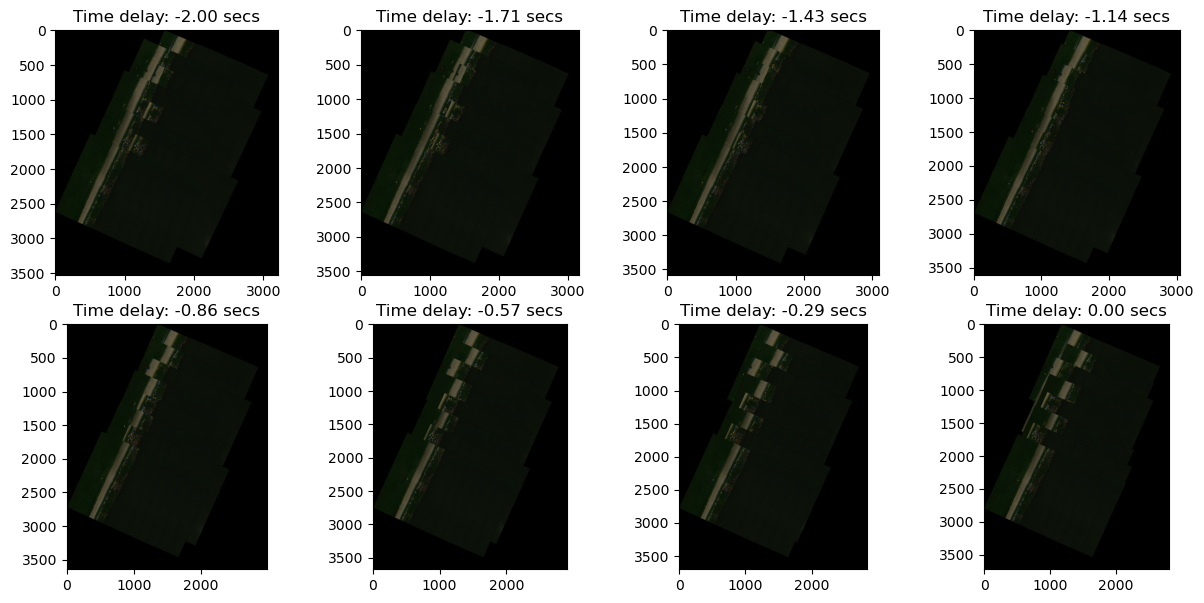

In [11]:
# estimate the bounds of time delay correction
est_time_delay1 = 0
est_time_delay2 = -2

# indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
estimate_angle = "coord"

IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = "coord")
df_interpolated = IF.interpolate_flight(plot=False)

n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,7))

for i, (td,ax) in enumerate(zip(np.linspace(est_time_delay2,est_time_delay1, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
    df_cropped = df1.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = 10)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.set_title(f'Time delay: {td:.2f} secs')
plt.show()

# Direct Georeferencing an image

[[  1.3190233 103.7365458]
 [  1.3189874 103.7366278]]
lat: 1.3190051, lon: 103.7365875, altitude: 51.013, yaw angle: -109.8711769249334
Flight angle from coords: 113.64403794598857
Flight height: 41.809
Flight direction: (-1.0, 1.0)
Flight angle: -113.64403794598857


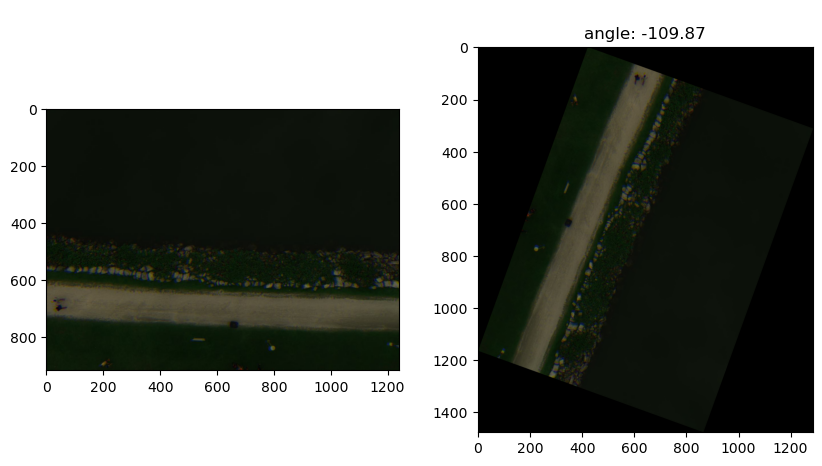

In [54]:
# import image and flight attributes
test_idx = 10

image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = height_min
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
lat,lon,altitude,dls_yaw = flight_attributes_df.iloc[test_idx,column_idx].tolist()
yaw_angle = -dls_yaw/np.pi*180
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
print(flight_att_diff)
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff, ref_vec=np.array([1,0]))
print(f'lat: {lat}, lon: {lon}, altitude: {altitude}, yaw angle: {yaw_angle}')
print(f'Flight angle from coords: {flight_angle_coord}')
print(f'Flight height: {altitude - DEM_offset_height}')

north_vec, east_vec = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight direction: {north_vec, east_vec}')

if east_vec < 0:
    flight_angle = flight_angle_coord # means rotation of image is positive (acw)
else:
    flight_angle = -flight_angle_coord # means rotation of image is negative (cw)
print(f'Flight angle: {flight_angle}')
GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                        altitude = altitude - 15,
                                        angle = yaw_angle)
_ = GI.georegister() # georeferenced file will be saved in cd if filename is provided
rot_im = GI.affine_transformation(plot=True)

# Georeference images in batch
- without time correction
- direct georeferencing

In [9]:
DEM_offset_height = height_min
# indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
estimate_angle = "coord"

georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),f'{estimate_angle}_georeferenced_thumbnails')
if not os.path.exists(georeferenced_thumbnails_directory):
    os.mkdir(georeferenced_thumbnails_directory)

thumbnails_directory = os.path.join(os.path.dirname(imagePath),'thumbnails')
if os.path.exists(thumbnails_directory):
    fp_list = [os.path.join(thumbnails_directory,fp) for fp in sorted(os.listdir(thumbnails_directory))]

else:
    fp_list = None

column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in tqdm(flight_attributes_df.iterrows()):
    if (i == 0) or (i == len(flight_attributes_df.index)-1):
        pass
    else:
        image_name = os.path.splitext(rows['image_name'])[0]
        lat,lon,altitude,dls_yaw = rows[column_idx].tolist()
        if estimate_angle == "yaw":
            # estimate flight angle directly from the yaw measurements
            flight_angle = -dls_yaw/np.pi*180
        else:
            # estimate flight angle from 2 adjacent coordinates
            flight_att_diff = flight_attributes_df.iloc[[i-1,i+1],column_idx]
            flight_att_diff = flight_att_diff.iloc[:,:2].values
            flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
            north_vec, east_vec = FlightAttributes.get_flight_direction(flight_att_diff)

            if east_vec < 0:
                flight_angle = flight_angle_coord # means rotation of image is positive (acw)
            else:
                flight_angle = -flight_angle_coord # means rotation of image is negative (cw)
        
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print(f"Image not found: {image_name}, {fp_list[i]}")
            pass
        else:
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                        altitude = altitude - DEM_offset_height,
                                        angle = flight_angle)
            GI.georegister(image_fn)


111it [01:40,  1.11it/s]


# Time delay correction
- based on the best time delay that produced the best alignment

111it [00:00, 1273.30it/s]
111it [00:00, 1384.62it/s]


rows shifted: -11
shape of canvas(3575, 3007, 3)


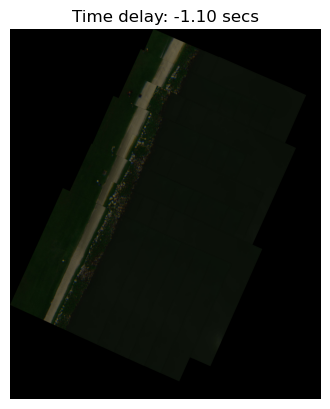

In [8]:
# indicate optimal time delay correction
td = -1.1
# indicate what method to estimate flight_angle in `estimate_angle`
estimate_angle = "coord"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = height_min
# interpolate df
IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight(plot=False)
df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
df_cropped = df_corrected.iloc[flight_points,:]
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
im_display = PG.plot_georeference(reduction_factor=5,plot=False)
plt.figure()
plt.imshow(im_display)
plt.axis('off')
plt.title(f'Time delay: {td:.2f} secs')
plt.show()

0it [00:00, ?it/s]

111it [00:00, 1459.42it/s]
111it [00:00, 1705.05it/s]


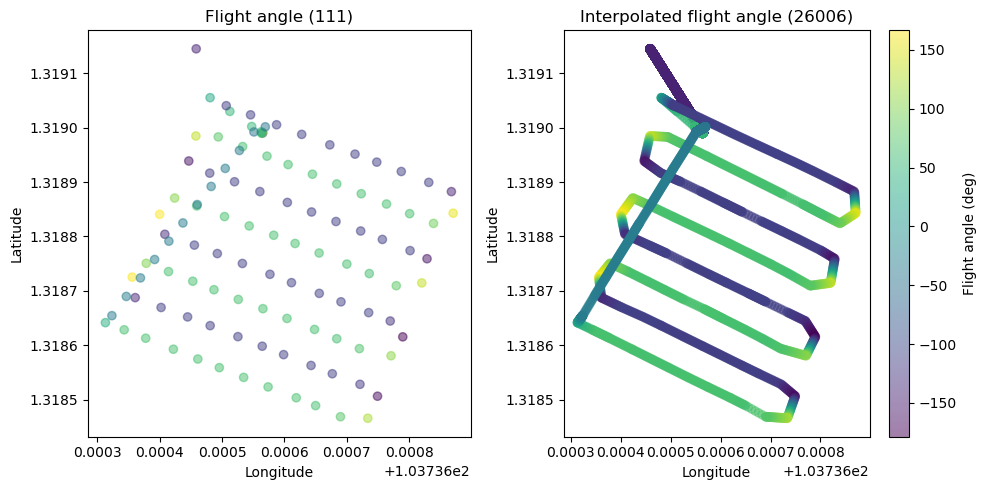

rows shifted: -11


111it [02:23,  1.29s/it]


In [12]:
IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight(plot=False)

df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)

# specify directory to save georeferenced images in
georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),f'corrected_{estimate_angle}_georeferenced_thumbnails')
if not os.path.exists(georeferenced_thumbnails_directory):
    os.mkdir(georeferenced_thumbnails_directory)

# check if rgb images are available
thumbnails_directory = os.path.join(os.path.dirname(imagePath),'thumbnails')
if os.path.exists(thumbnails_directory):
    fp_list = [os.path.join(thumbnails_directory,fp) for fp in sorted(os.listdir(thumbnails_directory))]

else:
    fp_list = None

# perform time delay correction
column_idx = [i for i,c in enumerate(df_corrected.columns.to_list()) if c in ['latitude','longitude','altitude','flight_angle']]
for i,rows in tqdm(df_corrected.iterrows()):
    if (i == 0) or (i >= len(df_corrected.index)-2):
        pass
    else:
        image_name = os.path.splitext(rows['image_name'])[0]
        lat,lon,altitude,flight_angle = rows[column_idx].tolist()
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print(f"Image not found: {image_name}, {fp_list[i]}")
            pass
        else:
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                        altitude = altitude - DEM_offset_height,
                                        angle = flight_angle)
            GI.georegister(image_fn)

# Radiometric correction

In [10]:
reflectance_directory = os.path.join(os.path.dirname(imagePath),'reflectance_images')
if not os.path.exists(reflectance_directory):
    os.mkdir(reflectance_directory)

img_list = [os.path.join(imagePath,f'IMG_{str(i).zfill(4)}_1.tif') for i in flight_points]

for i, fp in enumerate(img_list):
    fn = os.path.splitext(os.path.basename(fp))[0]
    reflectance_fn = os.path.join(reflectance_directory,f'{fn}.ob')

    cap = mutils.import_captures(fp)
    RI = espect.ReflectanceImage(cap,warp_matrices,cropped_dimensions)
    print('obtaining reflectance...')
    im_aligned = RI.get_aligned_reflectance()
    with open(reflectance_fn,'wb') as f:
        pickle.dump(im_aligned,f)

obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...
obtaining reflectance...


# Extract spectral information based on user-supplied WQL info

if there is no WQL info, stop here

In [10]:
# read in test wql df or supply your own filepath to the water quality csv file
# the csv file should have the columns lat, lon, measurements for simple standardisation
wql_df = pd.read_csv(r"saved_data\test_wql.csv")
wql_dict = wql_df.to_dict(orient='list')
wql_dict

{'lat': [1.318993,
  1.3189726842105265,
  1.318952368421053,
  1.318932052631579,
  1.3189117368421053,
  1.3188914210526317,
  1.318871105263158,
  1.3188507894736845,
  1.3188304736842107,
  1.3188101578947369,
  1.3187898421052633,
  1.3187695263157897,
  1.318749210526316,
  1.3187288947368423,
  1.3187085789473685,
  1.318688263157895,
  1.318667947368421,
  1.3186476315789477,
  1.3186273157894737,
  1.318607],
 'lon': [103.7369,
  103.73688421052633,
  103.73686842105263,
  103.73685263157896,
  103.73683684210526,
  103.73682105263158,
  103.73680526315788,
  103.7367894736842,
  103.73677368421052,
  103.73675789473684,
  103.73674210526316,
  103.73672631578948,
  103.7367105263158,
  103.73669473684213,
  103.73667894736842,
  103.73666315789474,
  103.73664736842105,
  103.73663157894735,
  103.73661578947367,
  103.7366],
 'measurements': [1.0,
  1.4736842105263157,
  1.9473684210526316,
  2.421052631578948,
  2.894736842105263,
  3.3684210526315788,
  3.842105263157895,


shape of canvas(3575, 3007, 3)


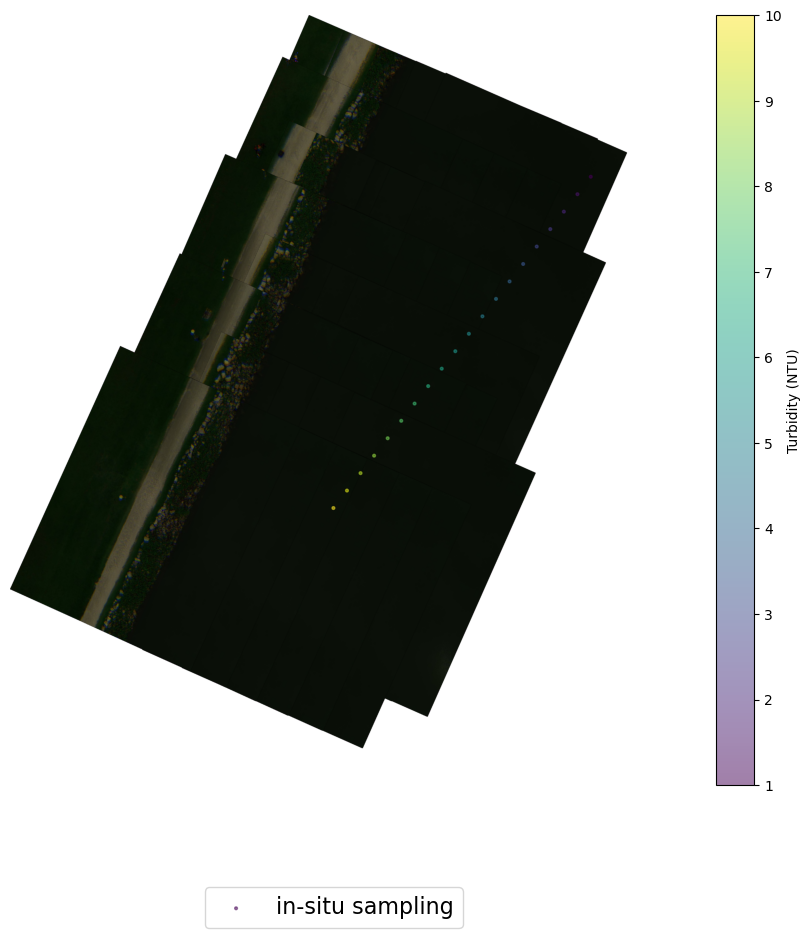

In [26]:
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,wql_dict,
                                       DEM_offset_height=height_min)
_ = PG.plot_georeference(reduction_factor = 5, plot = True, add_wql=True,
                         normalise=True,p_max=85,
                         s=4)

In [12]:
reflectance_directory = os.path.join(os.path.dirname(imagePath),'reflectance_images')
reflectance_fp_list = [os.path.join(reflectance_directory,fp) for fp in sorted(os.listdir(reflectance_directory))]
EIS = FlightAttributes.ExtractInsituSpectral(df_cropped,reflectance_fp_list,wql_dict,
                                       DEM_offset_height=height_min, radius = 1)
extracted_spectral = EIS.extract_spectral(os.path.join("saved_data","extracted_spectral.csv"))
extracted_spectral

c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,observation_number,image_index,tss_conc,tss_lat,tss_lon,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9
8,8,12,4.789474,1.318830,103.736774,0.045015,0.070974,0.049705,0.048988,0.053345,0.043401,0.057110,0.054375,0.058949,0.044208
9,9,12,5.263158,1.318810,103.736758,0.047872,0.079598,0.057379,0.050465,0.059985,0.046040,0.062551,0.063104,0.061981,0.048080
10,10,12,5.736842,1.318790,103.736742,0.038795,0.069811,0.045646,0.037476,0.047354,0.036521,0.050671,0.050497,0.050057,0.033480
1,1,13,1.473684,1.318973,103.736884,0.031816,0.058490,0.038834,0.030663,0.041558,0.029750,0.042801,0.042528,0.042863,0.028852
2,2,13,1.947368,1.318952,103.736868,0.038381,0.069510,0.045988,0.037172,0.048626,0.035078,0.050035,0.049489,0.050593,0.033944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,18,92,9.526316,1.318627,103.736616,0.040211,0.069348,0.044855,0.039596,0.048057,0.036410,0.050580,0.048506,0.049618,0.033947
19,19,92,10.000000,1.318607,103.736600,0.041255,0.071583,0.047071,0.041871,0.049815,0.037433,0.052224,0.051008,0.052045,0.036336
17,17,93,9.052632,1.318648,103.736632,0.037613,0.068115,0.042050,0.039286,0.046709,0.035661,0.049233,0.046573,0.047086,0.032918
18,18,93,9.526316,1.318627,103.736616,0.041186,0.072306,0.046939,0.043432,0.050722,0.038911,0.054238,0.051624,0.052049,0.037525


shape of canvas(3575, 3007, 3)


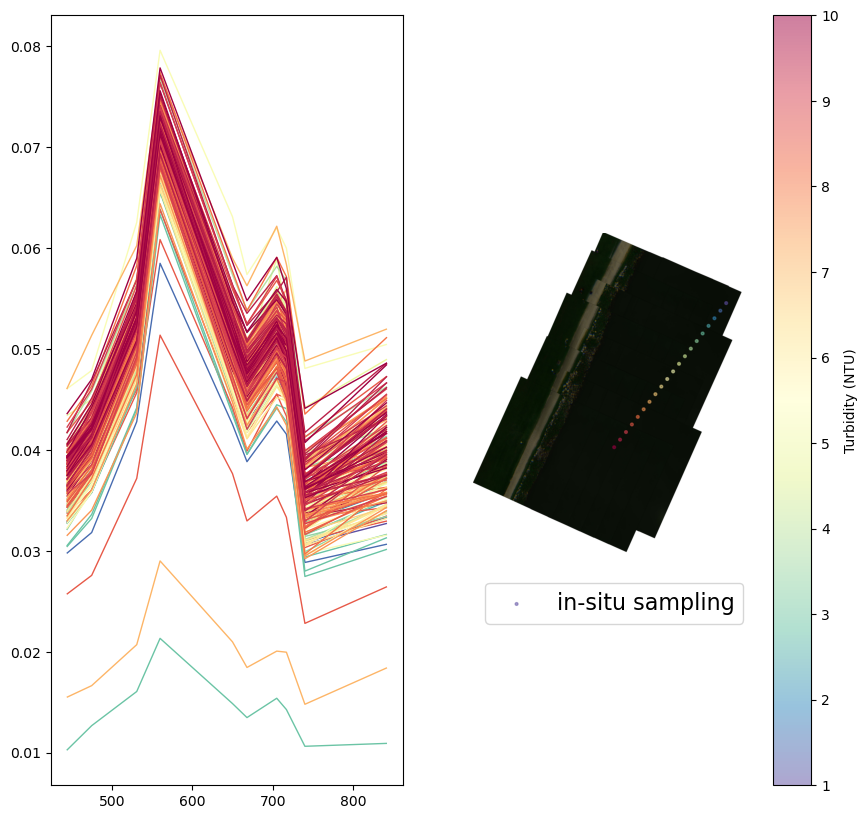

In [51]:
wavelengths = mutils.sort_bands_by_wavelength()
wavelength_dict = {i[0]:i[1] for i in wavelengths}
concentration = extracted_spectral.iloc[:,2].tolist()
wavelength = list(wavelength_dict.values())
wavelength_array = np.array([wavelength for i in range(len(concentration))])

df_reflectance = extracted_spectral.filter(regex=('band.*')).iloc[:,[i for i in list(wavelength_dict)]]
df_reflectance.columns = [f'{w:.2f}' for w in wavelength]
spectral_array = df_reflectance.values

fig, axes = plt.subplots(1,2,figsize=(10,10))
lc = ValidateAlgo.multiline(wavelength_array, spectral_array, concentration,ax=axes[0], cmap='Spectral_r', lw=1)
# lc.set_clim(min(concentration),max(concentration))
# fig.colorbar(lc, ax=axes[0])

PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,wql_dict,
                                       DEM_offset_height=height_min)
_ = PG.plot_georeference(reduction_factor = 5, plot = True, add_wql=True,
                         normalise=True,p_max=85,
                         axis=axes[1],
                         s=4,vmin=min(concentration),vmax=max(concentration),cmap='Spectral_r')
